# Visualization Capabilities from KerasCV

**Author:** [Usha Rengaraju](https://www.linkedin.com/in/usha-rengaraju-b570b7a2/)<br>
**Date created:** 2023/07/10<br>
**Last modified:** 2023/07/10<br>
**Description:** Discussion of visualization offerings from KerasCV

## Overview

KerasCV makes it very easy to visualise your datasets and bounding box predictions using the various image plotting utilities.

This guide will show you how to easily visualise the images and the object detection predictions using the kerasCV visualisation techniques and how to integrate them into your pipeline

This guide will show you how to compose these layers into your own data
augmentation pipeline for image classification tasks. This guide will also walk you
through the process of customizing a KerasCV data augmentation pipeline.

## Imports & setup

This tutorial requires you to have KerasCV installed:

```shell
pip install keras-cv
```

We begin by importing all required packages:

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import optimizers
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
import resource
from keras_cv import visualization
import tqdm

## Plotting a simple image using the plot image gallery option

We just take an image from the object dataset and visualise the image. There are various parameters which can be modified like scale, font_scale, bounding_box_format, class_mapping etc

1215963/1215963 [==============================] - 1s 1us/step


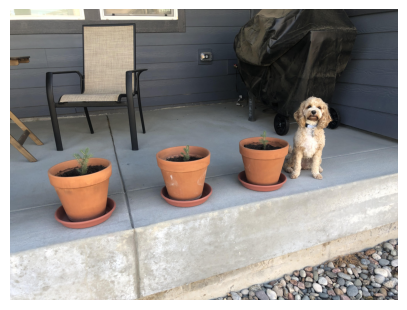

In [ ]:
filepath = tf.keras.utils.get_file(origin="https://storage.googleapis.com/cloud-ai-platform-97bb2539-a537-458c-96c8-389b8af9455a/gCNcJJI.jpg")
image = keras.utils.load_img(filepath)
image = np.array(image)

visualization.plot_image_gallery(
    [image],
    value_range=(0, 255),
    rows=1,
    cols=1,
    scale=5,
)

## Data loading

This guide uses the
[Pascal VOC 2007 Dataset](http://host.robots.ox.ac.uk/pascal/VOC/)
for demonstration purposes.

To get started, we first load the dataset:


In [ ]:
def unpackage_raw_tfds_inputs(inputs, bounding_box_format):
    image = inputs["image"]
    boxes = keras_cv.bounding_box.convert_format(
        inputs["objects"]["bbox"],
        images=image,
        source="rel_yxyx",
        target=bounding_box_format,
    )
    bounding_boxes = {
        "classes": tf.cast(inputs["objects"]["label"], dtype=tf.float32),
        "boxes": tf.cast(boxes, dtype=tf.float32),
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}


def load_pascal_voc(split, dataset, bounding_box_format):
    ds = tfds.load(dataset, split=split, with_info=False, shuffle_files=True)
    ds = ds.map(
        lambda x: unpackage_raw_tfds_inputs(x, bounding_box_format=bounding_box_format),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    return ds


train_ds = load_pascal_voc(
    split="train", dataset="voc/2007", bounding_box_format="xywh"
)
eval_ds = load_pascal_voc(split="test", dataset="voc/2007", bounding_box_format="xywh")

train_ds = train_ds.shuffle(4 * 4)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incompleteN7ICLM/voc-test.tfrecord*...:   0%|          | 0/…

Generating train examples...:   0%|          | 0/2501 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incompleteN7ICLM/voc-train.tfrecord*...:   0%|          | 0…

Generating validation examples...:   0%|          | 0/2510 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incompleteN7ICLM/voc-validation.tfrecord*...:   0%|        …

Dataset voc downloaded and prepared to /root/tensorflow_datasets/voc/2007/4.0.0. Subsequent calls will reuse this data.


In [ ]:
train_ds = train_ds.ragged_batch(4, drop_remainder=True)
eval_ds = eval_ds.ragged_batch(4, drop_remainder=True)

In [ ]:
class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Dining Table",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted Plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

## Visualising the dataset along with the bounding boxes using the plot bounding box gallery option

### Training set

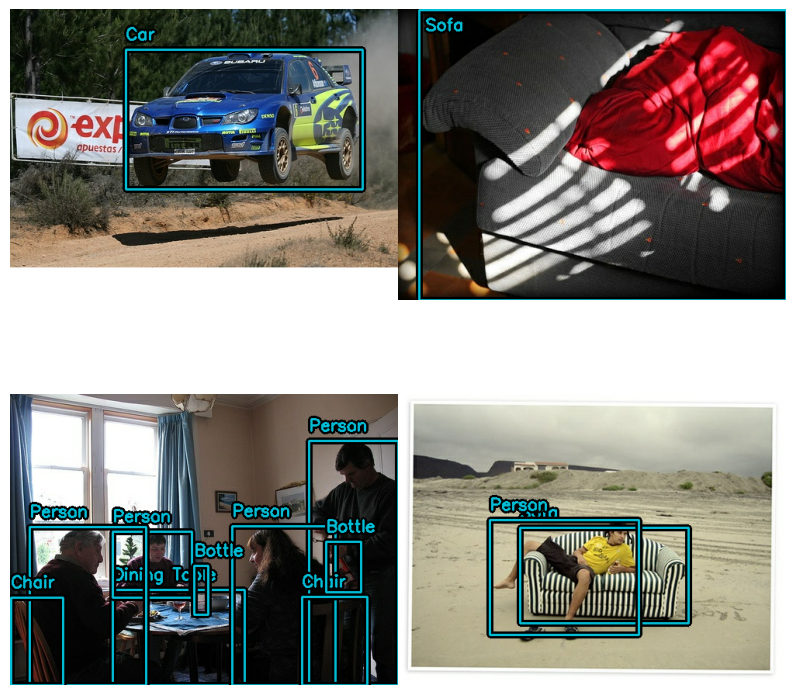

In [ ]:
inputs = next(iter(train_ds.take(1)))
images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
visualization.plot_bounding_box_gallery(
    images,
    value_range=(0,255),
    rows=2,
    cols=2,
    y_true=bounding_boxes,
    scale=5,
    font_scale=0.7,
    bounding_box_format='xywh',
    class_mapping=class_mapping,
)

### Evaluation Set

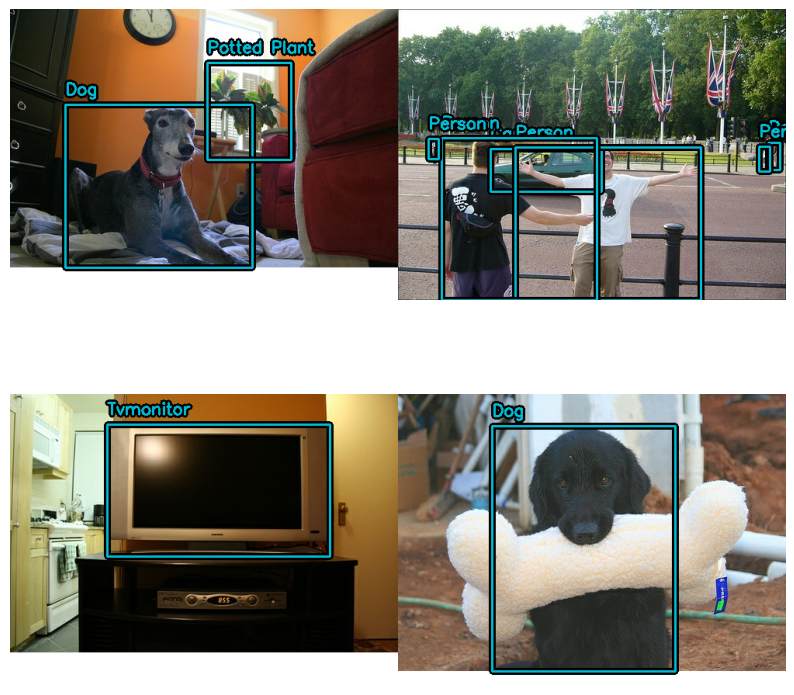

In [ ]:
inputs = next(iter(eval_ds.take(1)))
images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
visualization.plot_bounding_box_gallery(
    images,
    value_range=(0,255),
    rows=2,
    cols=2,
    y_true=bounding_boxes,
    scale=5,
    font_scale=0.7,
    bounding_box_format='xywh',
    class_mapping=class_mapping,
)

## KerasCV visualisation for verifying augementation
You can easily use the kerascv visualisation to verify your augmentation. Lets see this with a simple example. We create a simple augmentation pipeline using the kerasCV layers including the `RandomFlip`, `RandomHue`, `RandomSaturation` and `JitteredResize`, and then apply this to our training dataset.

We take one batch out of this augmented dataset and visualise it using the available `plot_bounding_box_gallery` function.

For the Evaluation dataset we just apply the resize layer to make it consistent with the model

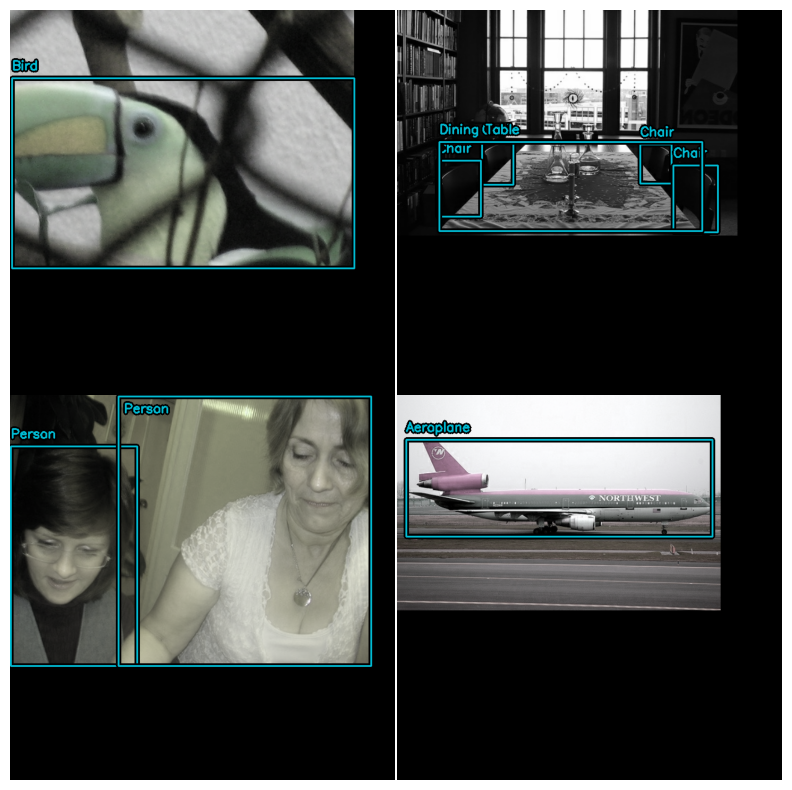

In [ ]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xywh"),
        keras_cv.layers.RandomHue((0.2,0.2),(0,255)),
        keras_cv.layers.RandomSaturation((0.2,0.2)),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xywh"
        ),
    ]
)

train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)
inputs = next(iter(train_ds.take(1)))
images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
visualization.plot_bounding_box_gallery(
    images,
    value_range=(0,255),
    rows=2,
    cols=2,
    y_true=bounding_boxes,
    scale=5,
    font_scale=0.7,
    bounding_box_format='xywh',
    class_mapping=class_mapping,
)

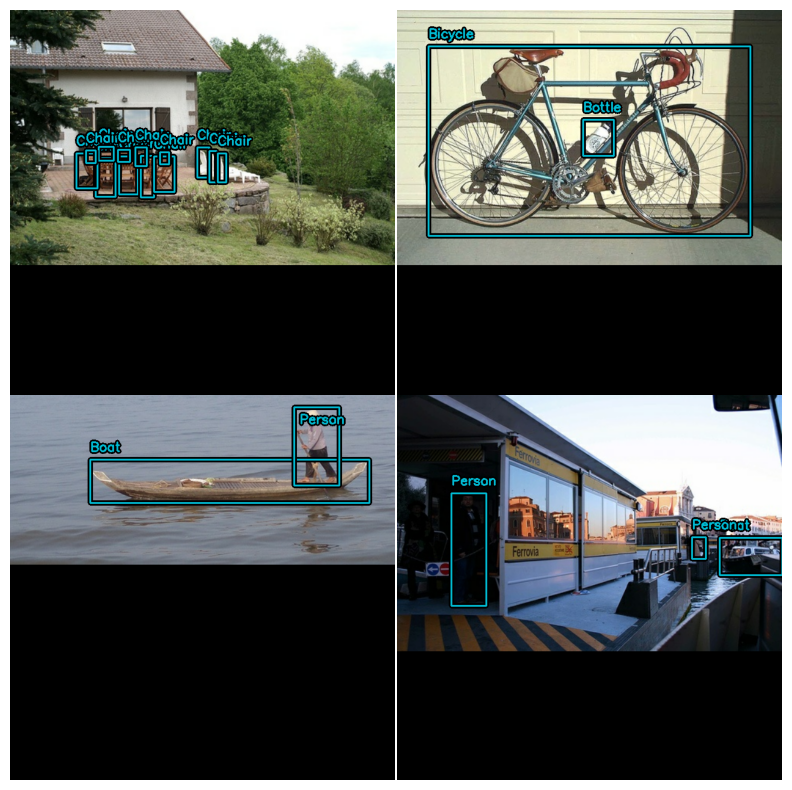

In [ ]:
inference_resizing = keras_cv.layers.Resizing(
    640, 640, bounding_box_format="xywh", pad_to_aspect_ratio=True
)
eval_ds = eval_ds.map(inference_resizing, num_parallel_calls=tf.data.AUTOTUNE)
inputs = next(iter(eval_ds.take(1)))
images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
visualization.plot_bounding_box_gallery(
    images,
    value_range=(0,255),
    rows=2,
    cols=2,
    y_true=bounding_boxes,
    scale=5,
    font_scale=0.7,
    bounding_box_format='xywh',
    class_mapping=class_mapping,
)

## KerasCV also provides us a very convinient and easy way to visualise the object detection model predictions

In the example below we load a pretrained yolov8 detector from KerasCV and use it to make predictions on the dataset and we can see that we can directly feed the predictions into the visualisation function without any processing requried. This makes the bounding box predictions very easy to visualise.

In [ ]:
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc", bounding_box_format="xywh"
)


151780576/151780576 [==============================] - 2s 0us/step


1/1 [==============================] - 13s 13s/step


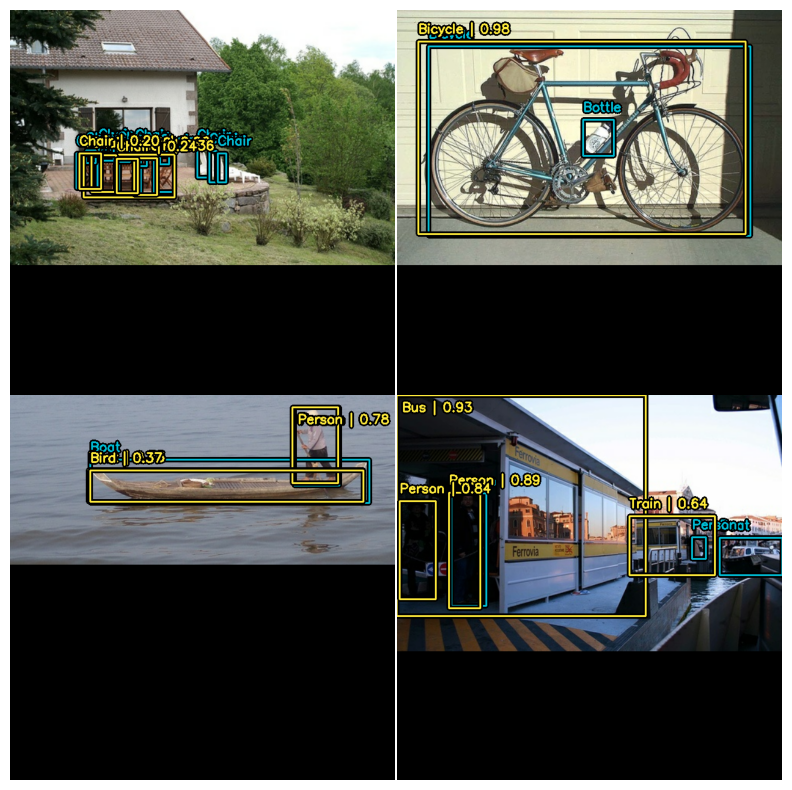

In [ ]:
y_pred = pretrained_model.predict(images)

visualization.plot_bounding_box_gallery(
    images,
    value_range=(0, 255),
    rows=2,
    cols=2,
    y_pred=y_pred,
    y_true=bounding_boxes,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)